In [1]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import oracledb
import getpass
from scipy import stats

In [2]:
def rank_rep_performance(file_path, sheet_name, output_file):
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    
    # Manually define columns that contain rank values
    rank_cols = ['2016 Rank', '2017 Rank', '2018 Rank', '2019 Rank', 
                 '2020 Rank', '2021 Rank', '2022 Rank', '2023 Rank', 'YTD April 2024 Rank']
    
    # Count the # of years for which each rep has a ranking (i.e. tenure)
    df['Total Yrs'] = df[rank_cols].notna().sum(axis=1)
    
    # Filter out any reps who have less than 3 years' tenure
    filtered_df = df[df['Total Yrs'] >= 3].copy()
    
    top_quartile = round(filtered_df.shape[0] / 4)
    percent_in_top_col_name = f'% in Top {top_quartile}'
    count_in_top_col_name = f'# in Top {top_quartile}'
    
    # Re-calculate ranks for remaining reps (i.e. re-rank without reps with less than 3 years' tenure)
    for year in rank_cols:
        filtered_df[year] = filtered_df[year].rank(method='min', na_option='keep')
    
    filtered_df[count_in_top_col_name] = ((filtered_df[rank_cols] > 0) & (filtered_df[rank_cols] <= top_quartile)).sum(axis=1)
    filtered_df[percent_in_top_col_name] = filtered_df[count_in_top_col_name] / filtered_df['Total Yrs']
    filtered_df['Highest Rank'] = filtered_df[rank_cols].min(axis=1)
    filtered_df['Mean Rank'] = filtered_df[rank_cols].mean(axis=1)
    filtered_df['Median Rank'] = filtered_df[rank_cols].median(axis=1)
    
    output_df = filtered_df[['Reg', 'Ty', 'Rep', count_in_top_col_name, 'Total Yrs', percent_in_top_col_name, 
                    'Highest Rank', 'Mean Rank', 'Median Rank']].copy()
    
    output_df = output_df.sort_values(by=[percent_in_top_col_name, 'Total Yrs'], ascending=False).reset_index(drop=True)

    mean_value = output_df[percent_in_top_col_name].mean()
    median_value = output_df[percent_in_top_col_name].median()
    std_dev = output_df[percent_in_top_col_name].std()
    
    bottom_std_dev = output_df[percent_in_top_col_name].mean() - std_dev
    top_std_dev = output_df[percent_in_top_col_name].mean() + std_dev
    
    print('Mean + 1 Std Dev: ', bottom_std_dev)
    print('Mean - 1 Std Dev: ', top_std_dev)

    # Calculate absolute differences
    absolute_diff_bottom = abs(output_df[percent_in_top_col_name] - bottom_std_dev)
    absolute_diff_top = abs(output_df[percent_in_top_col_name] - top_std_dev)

    # Find index of value w/ minimum difference
    closest_index_bottom = absolute_diff_bottom.idxmin()
    closest_index_top = absolute_diff_top.idxmin()

    # Get the value closest to target
    closest_value_bottom = output_df.at[closest_index_bottom, percent_in_top_col_name]
    closest_value_top = output_df.at[closest_index_top, percent_in_top_col_name]

#     print("Closest value bottom:", closest_value_bottom)
#     print("Closest value top:", closest_value_top)
    
    output_df['Performance Category'] = 'average'
    output_df.loc[output_df[percent_in_top_col_name] <= closest_value_bottom, 'Performance Category'] = 'low'
    output_df.loc[output_df[percent_in_top_col_name] >= closest_value_top, 'Performance Category'] = 'high'

    plt.figure(figsize=(8, 4))
    plt.hist(output_df[percent_in_top_col_name], bins=50, color='skyblue', edgecolor='black')
    plt.axvline(x=mean_value, color='red', linestyle='--', label='Mean')
    plt.axvline(x=median_value, color='orange', linestyle='--', label='Median')
    plt.axvline(x=output_df[percent_in_top_col_name].mean() + std_dev, color='green', linestyle='--', label='Mean + 1 Std Dev')
    plt.axvline(x=output_df[percent_in_top_col_name].mean() - std_dev, color='green', linestyle='--', label='Mean - 1 Std Dev')
    plt.title('% of Tenure Ranked in Top Quartile')
    plt.xlabel('% of Tenure Ranked in Top Quartile')
    plt.ylabel('# of Reps')
    plt.grid(True)
    plt.show()
    
    output_file_path = f'{output_file}.xlsx'
    output_df.to_excel(output_file_path, index=False)
    print(f"Data has been successfully written to {output_file_path}")

Mean + 1 Std Dev:  0.12468018450835416
Mean - 1 Std Dev:  0.5065228230104427


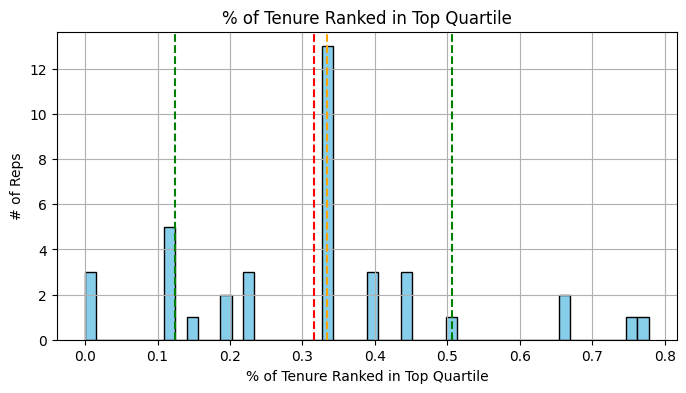

Data has been successfully written to AE-Rep-Rank-Summary.xlsx


In [4]:
rank_rep_performance('Rep-Rank-Summary.xlsx', 'Summary (Ranking AE)', 'AE-Rep-Rank-Summary')

Mean + 1 Std Dev:  0.08462665059937721
Mean - 1 Std Dev:  0.44502414305141635


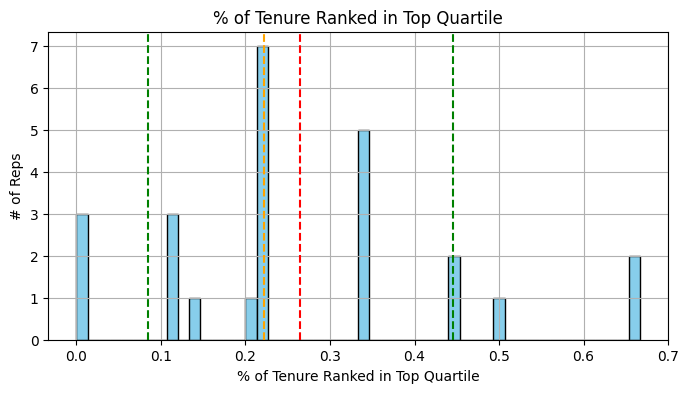

Data has been successfully written to SAE-Rep-Rank-Summary.xlsx


In [5]:
rank_rep_performance('Rep-Rank-Summary.xlsx', 'Summary (Ranking SAE)', 'SAE-Rep-Rank-Summary')